In [1]:
import os 
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F 
import cv2

## Introduction 

This is a simplified version of updating image over a mask region, mainly to give reader of the coder an understanding of hot to update gradient over a specific region and how the receptive field may influyence the whole things


In [2]:
# Use only first 10 layer to train the update 
model = models.vgg16(pretrained=True).features
net = nn.Sequential()
for i, layer in enumerate(list(model)):
    if i <= 9:
        net.add_module(str(len(net)), layer)
print(net)
for param in net.parameters(): # freeze new added loss layer 
    param.requires_grad = False


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


## Set Data, Target


In [3]:
def tensor_to_np_img(x):
    x_np = x.detach().numpy()
    x_np = np.squeeze(x_np, axis=0)
    x_np = np.dstack((x_np[0, :, :], x_np[1, :, :], x_np[2, :, :]))
    return x_np

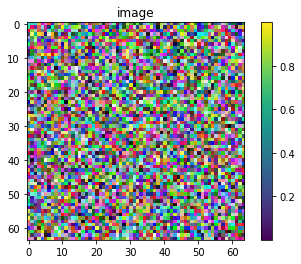

In [4]:
img = torch.rand((1, 3, 64, 64))
img = nn.Parameter(img)
plt.figure()
plt.title('image')
plt.imshow(tensor_to_np_img(img))
plt.colorbar()
plt.show()

## Simple Update using optimzier 

**NOTICE** this type of update may influence the whole receptive field 

In [5]:
optimizer = optim.Adam([img], 1e-2)

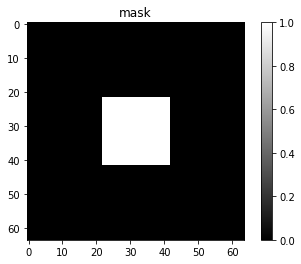

mask shape is: torch.Size([1, 1, 64, 64])


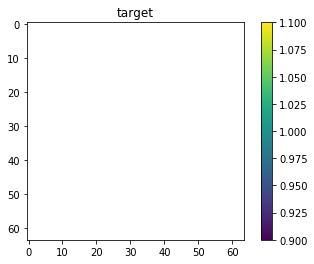

In [6]:
target = torch.ones((img.shape))
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 22:42, 22:42] = 1 
plt.figure()
plt.title('mask')
plt.imshow(mask[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()
print('mask shape is:',mask.shape)
plt.figure()
plt.title('target')
plt.imshow(tensor_to_np_img(target))
plt.colorbar()
plt.show()


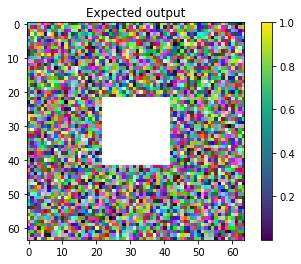

Expected output shape : torch.Size([1, 3, 64, 64])


In [7]:
expected_output = (1-mask.expand(img.shape)) * img + mask.expand(img.shape) * target
plt.figure()
plt.imshow(tensor_to_np_img(expected_output))
plt.title('Expected output')
plt.colorbar()
plt.show()
print('Expected output shape :', expected_output.shape)

In [8]:
target_fm = net(target)
print(target_fm.shape)

torch.Size([1, 128, 16, 16])


In [9]:
mask_fm = F.interpolate(mask, scale_factor=(0.25, 0.25))
mask_fm = mask_fm.expand(target_fm.shape)
print(mask_fm.shape)

torch.Size([1, 128, 16, 16])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


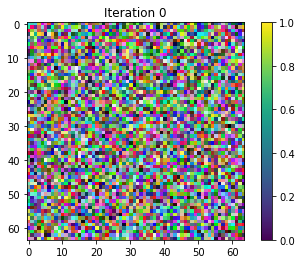

Iteration 0
Iteration 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


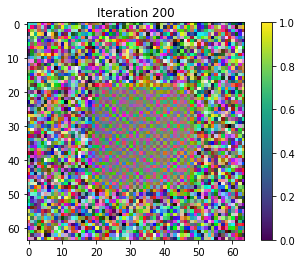

Iteration 200
Iteration 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


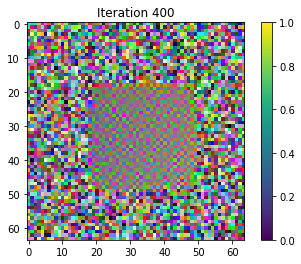

Iteration 400
Iteration 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


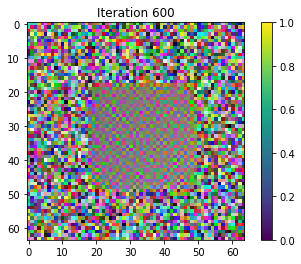

Iteration 600
Iteration 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


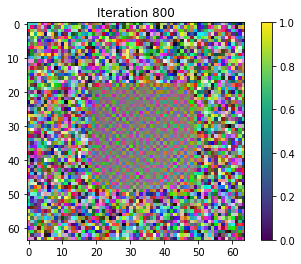

Iteration 800
Iteration 900


In [10]:
i = 0
while i < 1000:
    optimizer.zero_grad()
    img_fm = net(img)
    diff = (img_fm - target_fm)**2
    diff_mask = diff * mask_fm
    loss = torch.sum(diff_mask)
    loss.backward()
    optimizer.step()
    if i % 200 == 0:
        img_np = tensor_to_np_img(img)
        plt.imshow(img_np)
        plt.colorbar()
        plt.title('Iteration {}'.format(str(i)))
        plt.show()
    if i % 100 == 0:
        print('Iteration {}'.format(i))
    i += 1

## Mask Gradient to update

**NOTICE** this deal with the problem that the whole receptive field is updated 

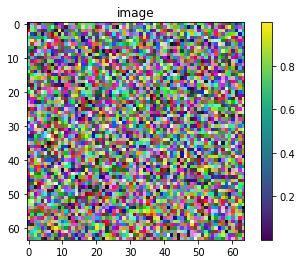

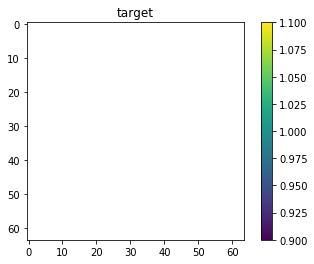

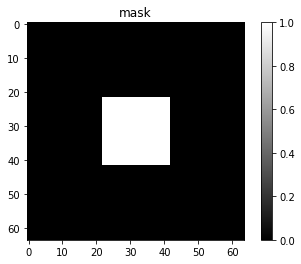

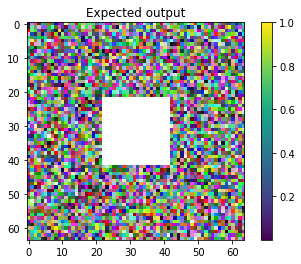

In [11]:
# Define image, mask, target like we did in the previous step 

# Image 
img = torch.rand((1, 3, 64, 64))
img = nn.Parameter(img)
plt.figure()
plt.title('image')
plt.imshow(tensor_to_np_img(img))
plt.colorbar()
plt.show()

img_fm = net(img)

# Target 
target = torch.ones((img.shape))
plt.figure()
plt.title('target')
plt.imshow(tensor_to_np_img(target))
plt.colorbar()
plt.show()

# Mask 
mask = torch.zeros((1, 1, img.shape[2], img.shape[3]))
mask[0, 0, 22:42, 22:42] = 1 
mask_img = mask.expand(img.shape)
mask_fm = F.interpolate(mask, scale_factor=(0.25, 0.25))
mask_fm = mask_fm.expand(img_fm.shape)

plt.figure()
plt.title('mask')
plt.imshow(mask[0,0,:,:], cmap='gray')
plt.colorbar()
plt.show()

# Expected output 
expected_output = (1-mask_img) * img + mask_img * target
plt.figure()
plt.imshow(tensor_to_np_img(expected_output))
plt.title('Expected output')
plt.colorbar()
plt.show()

# Target fm ( or style feature map )
target_fm = net(expected_output).detach()
target_fm.require_grad = False

In [12]:
optimizer = optim.Adam([img], 1e-2)

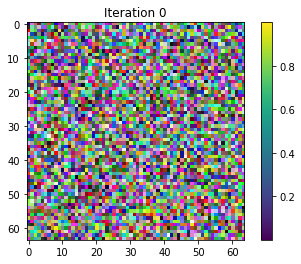

Iteration 0
Iteration 100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


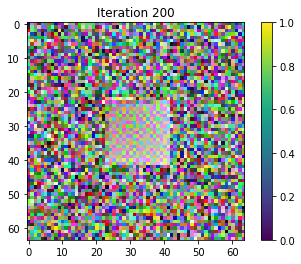

Iteration 200
Iteration 300


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


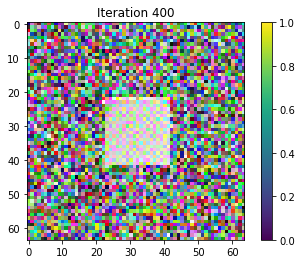

Iteration 400
Iteration 500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


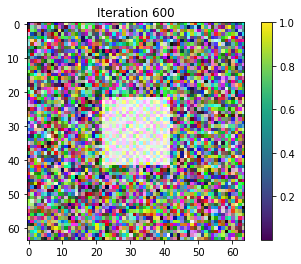

Iteration 600
Iteration 700


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


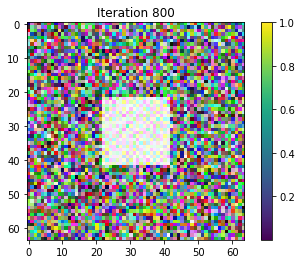

Iteration 800
Iteration 900


In [13]:
i = 0
def closure():
    optimizer.zero_grad()
    img_fm = net(img)
    diff = (img_fm - target_fm)**2
    diff_mask = diff * mask_fm
    loss = torch.sum(diff_mask)
    loss.backward()
    img.grad = img.grad * mask_img
    if i % 200 == 0:
        img_np = tensor_to_np_img(img)
        plt.imshow(img_np)
        plt.colorbar()
        plt.title('Iteration {}'.format(str(i)))
        plt.show()
    if i % 100 == 0:
        print('Iteration {}'.format(i))
    
while i < 1000:
    optimizer.step(closure)
    i += 1
    